In [ ]:
# 项目结构
.
├── Dockerfile                         # Docker 镜像构建文件，用于容器化部署项目环境
├── Main.ipynb                         # 主 Jupyter Notebook 文件，可能用于交互式开发、演示或整合训练流程
├── README.md                          # 项目说明文档，通常包含安装、使用和结果概要等信息
│
├── data/                              # 原始数据与预处理后的数据文件存放目录
│   ├── CA.smi                         # 化学结构的 SMILES 格式文件（例如：阴离子/阳离子对）
│   ├── MP.txt                         # 熔点（Melting Point）原始标签数据
│   ├── VISCOSITY.txt                  # 粘度（Viscosity）原始标签数据
│   ├── melting_point_id_data.pkl      # 熔点任务对应的分子 ID 与标签映射（pickle 序列化）
│   ├── mp_graph_data.pkl              # 熔点任务的图结构数据（分子图，已序列化）
│   ├── mp_id_data.pkl                 # 可能为熔点任务的备用 ID 映射
│   ├── pairs.csv                      # 阴阳离子配对信息（用于构建离子液体）
│   ├── viscosity_graph_data.pkl       # 粘度任务的图结构数据
│   ├── viscosity_id_data.pkl          # 粘度任务的 ID 与标签映射
│   └── vocab.pkl                      # 分子子结构词汇表（用于图神经网络的原子/键特征编码）
│
├── environment.yml                    # Conda 环境配置文件，定义了 Python 及依赖包版本
│
├── logs/                              # 训练日志输出目录
│   ├── log_melting_point.txt          # 熔点模型训练日志（如 loss、指标等）
│   ├── log_melting_point_transfer.txt # 迁移学习熔点模型的日志
│   └── log_viscosity.txt              # 粘度模型训练日志
│
├── models/                            # 模型文件与自定义层定义
│   ├── bond_matrix_message.py         # 自定义 GNN 消息传递层（如 BondMatrixMessage）
│   ├── layers.py                      # 其他自定义 Keras/TensorFlow 层（如 MPNN 层）
│   ├── melting_point_final.keras      # 训练完成的熔点预测模型（Keras 格式）
│   ├── melting_point_transfer_final.keras  # 迁移学习后的熔点模型
│   ├── mp_norm_params.pkl             # 熔点标签的归一化参数（如 mean/std）
│   └── viscosity_final.keras          # 训练完成的粘度预测模型
│
├── results/                           # 训练结果与可视化输出
│   ├── figure2_a_viscosity.png        # 粘度预测结果图（如 parity plot）
│   ├── figure2_b_melting_point.png    # 熔点预测结果图
│   ├── figure2_c_melting_point_transfer.png  # 迁移学习熔点结果图
│   ├── history_*.pkl                  # 训练历史记录（如 loss、val_loss、R² 等）
│   ├── loss_*.png                     # 训练/验证 loss 曲线图
│   └── *_scaler.pkl                   # 迁移学习任务中使用的特征/标签缩放器（如 MinMaxScaler）
│
├── scripts/                           # 辅助脚本
│   └── prepare_pairs.py               # 用于生成阴阳离子配对数据（如从 SMILES 构建 pairs.csv）
│
├── src/                               # 核心数据处理与特征工程代码
│   ├── build_vocab.py                 # 构建图神经网络所需的子结构词汇表
│   ├── dataset.py                     # 自定义 TensorFlow/Keras Dataset 类或数据加载器
│   ├── featurize.py                   # 将分子 SMILES 转换为图特征（原子/键特征、邻接矩阵等）
│   └── parse_data.py                  # 解析原始 MP.txt / VISCOSITY.txt 等标签文件
│
├── train_melting_point.py            # 熔点预测模型的主训练脚本
├── train_melting_point_transfer.py   # 基于迁移学习的熔点预测训练脚本
├── train_viscosity.py                # 粘度预测模型的主训练脚本
│
└── utils/                             # 工具函数模块
    └── mp_utils.py                    # 熔点任务专用的辅助函数（如评估、后处理等）

## 一、粘度预测模型（Viscosity Prediction）

本代码实现了一个**基于离子对 SMILES 结构的离子液体粘度预测模型**，整体设计严格参考论文  
**《Predicting Ionic Liquid Materials Properties from Chemical Structure》**，用于复现实验并支持后续迁移学习。

---
### 1、模型整体思路
模型以**阳离子 / 阴离子的分子图结构**为输入，使用 **Message Passing Neural Network (MPNN)** 分别对两种离子进行编码，再将其特征进行融合，最终在**物理约束条件下**预测粘度的对数值。

---
### 2、核心结构
- **输入**
  - 阳离子与阴离子的：
    - 原子类别（atom ids）
    - 键类型（bond ids）
    - 图连接关系（edge indices）
  - 温度 `T`（显式作为模型输入）
- **分子编码（MPNN）**
  - 原子 / 键嵌入（Embedding）
  - 多步消息传递（BondMatrixMessage + GatedUpdate）
  - 全局池化（GlobalSumPool）得到分子指纹
- **离子对融合**
  - 对阳离子与阴离子指纹进行逐元素相加（paper-consistent）
  - 经全连接层生成粘度物理参数
---

### 3、物理约束粘度头
模型并非直接回归粘度，而是学习物理参数：
\[
\log(\eta) = A + \frac{B}{T + C}
\]
其中：
- \(A\)：无约束偏置项  
- \(B\)：通过 `softplus + clip` 约束为正值  
- \(C\)：保证温度平移项为合理正区间  
- 温度 \(T\) 进行物理尺度归一化  
---

### 4、训练与评估
- **数据划分**
  - 默认采用论文中的随机划分（存在 pair-level leakage）
  - 代码中预留了 **严格无泄漏划分（按离子对）** 的可选方案
- **训练设置**
  - Optimizer：Adam（带梯度裁剪）
  - Loss：MSE
  - Early Stopping 防止过拟合
  - 自定义 Callback 控制关键 epoch 输出
- **评估指标**
  - R²（决定系数）
  - MAE（平均绝对误差）
---

### 5、结果可视化与保存
- 绘制训练 / 验证损失曲线
- 生成论文对应的 **Figure 2(a)**：实验值 vs 预测值散点图
- 保存最终模型为 `.keras` 格式，用于后续迁移学习任务


===== Viscosity prediction performance =====
192/192 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step
Train: R2 = 0.8995, MAE = 0.1610
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step
Dev: R2 = 0.8685, MAE = 0.1817
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step
Test: R2 = 0.8620, MAE = 0.1790
192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


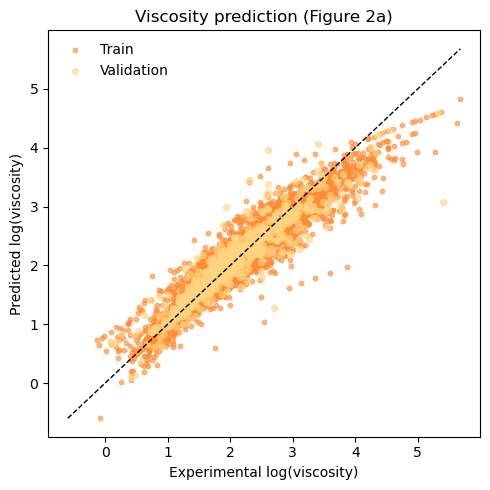

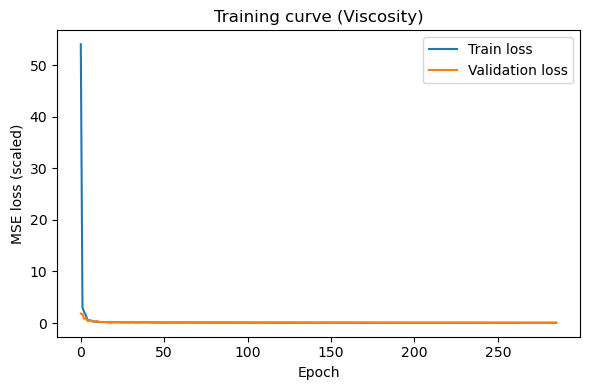

In [18]:
# ============================================================
# Notebook: Viscosity results visualization (Figure 2a)
# 打印 R² / MAE + Figure 2(a) + Loss 曲线
# ============================================================

# ---------- 环境 & 导入 ----------
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["ABSL_LOG_LEVEL"] = "2"
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split

# 自定义层
from models.layers import (
    BondMatrixMessage, 
    GatedUpdate, 
    GlobalSumPool,
    Reduce, 
    AddTwoTensors, 
    SliceParamA, 
    SliceParamB, 
    SliceParamC,
    ScaleTemperature,
    ComputeLogEta
)

# 复用训练脚本中的工具函数（保持一致性）
from train_viscosity import (
    r2_numpy,
    pad_sequences_1d,
    preprocess_edges_and_bonds,
    plot_loss
)


# ============================================================
# 1. 加载数据
# ============================================================

with open("data/viscosity_id_data.pkl", "rb") as f:
    data = pickle.load(f)

y_all = np.array([d["log_eta"] for d in data], np.float32)

cat_atoms = [[a + 1 for a in d["cation"]["atom_ids"]] for d in data]
cat_bonds = [[b + 1 for b in d["cation"]["bond_ids"]] for d in data]
cat_edges = [d["cation"]["edge_indices"] for d in data]

an_atoms  = [[a + 1 for a in d["anion"]["atom_ids"]] for d in data]
an_bonds  = [[b + 1 for b in d["anion"]["bond_ids"]] for d in data]
an_edges  = [d["anion"]["edge_indices"] for d in data]

T = np.array([d["T"] for d in data], np.float32)[:, None]


# ============================================================
# 2. 数据划分（与 train_viscosity.py 完全一致）
# ============================================================

indices = np.arange(len(data))
idx_train, idx_tmp = train_test_split(indices, test_size=0.20, random_state=42)
idx_dev, idx_test  = train_test_split(idx_tmp, test_size=0.50, random_state=42)

y_train = y_all[idx_train]
y_dev   = y_all[idx_dev]
y_test  = y_all[idx_test]


# ============================================================
# 3. Padding 长度
# ============================================================

max_atoms = max(max(map(len, cat_atoms)), max(map(len, an_atoms)))
max_edges = max(max(map(len, cat_edges)), max(map(len, an_edges)))


# ============================================================
# 4. 构建模型输入
# ============================================================

def build_inputs(idxs):
    ce, cb = preprocess_edges_and_bonds(
        [cat_edges[i] for i in idxs],
        [cat_bonds[i] for i in idxs],
        max_edges
    )
    ae, ab = preprocess_edges_and_bonds(
        [an_edges[i] for i in idxs],
        [an_bonds[i] for i in idxs],
        max_edges
    )
    return {
        "cat_atom": pad_sequences_1d([cat_atoms[i] for i in idxs], max_atoms),
        "cat_bond": cb,
        "cat_connectivity": ce,
        "an_atom": pad_sequences_1d([an_atoms[i] for i in idxs], max_atoms),
        "an_bond": ab,
        "an_connectivity": ae,
        "temperature": T[idxs],
    }

x_train = build_inputs(idx_train)
x_dev   = build_inputs(idx_dev)
x_test  = build_inputs(idx_test)


# ============================================================
# 5. 加载模型
# ============================================================

model = keras.models.load_model(
    "models/viscosity_final.keras",
    custom_objects={
        "BondMatrixMessage": BondMatrixMessage,
        "GatedUpdate": GatedUpdate,
        "GlobalSumPool": GlobalSumPool,
        "Reduce": Reduce,
        "AddTwoTensors": AddTwoTensors,
        "SliceParamA": SliceParamA,
        "SliceParamB": SliceParamB,
        "SliceParamC": SliceParamC,
        "ScaleTemperature": ScaleTemperature,
        "ComputeLogEta": ComputeLogEta,
    }
)



# ============================================================
# 6. 打印 Train / Dev / Test 的 R² 和 MAE
# ============================================================

print("===== Viscosity prediction performance =====")

for name, x_, y_ in [
    ("Train", x_train, y_train),
    ("Dev",   x_dev,   y_dev),
    ("Test",  x_test,  y_test)
]:
    pred = model.predict(x_).flatten()
    print(
        f"{name}: "
        f"R2 = {r2_numpy(y_, pred):.4f}, "
        f"MAE = {np.mean(np.abs(y_ - pred)):.4f}"
    )


# ============================================================
# 7. 绘制 Figure 2(a)：训练 + 验证
# ============================================================

y_train_pred = model.predict(x_train).flatten()
y_dev_pred   = model.predict(x_dev).flatten()

plt.figure(figsize=(5, 5))

# Train：深橘
plt.scatter(
    y_train,
    y_train_pred,
    s=10,
    alpha=0.6,
    color="#FF8B32",
    label="Train"
)

# Dev：浅橘
plt.scatter(
    y_dev,
    y_dev_pred,
    s=18,
    alpha=0.6,
    color="#FFD582BE",
    label="Validation"
)

low = min(y_train.min(), y_dev.min(), y_train_pred.min(), y_dev_pred.min())
high = max(y_train.max(), y_dev.max(), y_train_pred.max(), y_dev_pred.max())
plt.plot([low, high], [low, high], "k--", linewidth=1)

plt.xlabel("Experimental log(viscosity)")
plt.ylabel("Predicted log(viscosity)")
plt.title("Viscosity prediction (Figure 2a)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


# ============================================================
# 8. 绘制损失曲线（来自 history.pkl）
# ============================================================

with open("results/history_viscosity.pkl", "rb") as f:
    history_dict = pickle.load(f)

class DummyHistory:
    def __init__(self, history):
        self.history = history

dummy_history = DummyHistory(history_dict)

plt.figure(figsize=(6, 4))
plt.plot(dummy_history.history["loss"], label="Train loss")
plt.plot(dummy_history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss (scaled)")
plt.title("Training curve (Viscosity)")
plt.legend()
plt.tight_layout()
plt.show()


## 粘度模型实验总结

- 本实验成功复现了 Quill 等人提出的基于消息传递神经网络（Message Passing Neural Network, MPNN）的离子液体粘度预测模型。模型以离子液体的阳离子与阴离子分子结构（以分子图形式表示）及温度作为输入，通过共享权重的消息传递网络对分子结构信息进行编码，并在此基础上结合具有物理约束形式的粘度预测头完成回归任务。
- 在 viscosity 数据集上，模型在训练集、验证集和测试集上分别取得了良好的预测性能，表现为训练集 $R^2=0.8995$、验证集 $R^2=0.8685$，对应的平均绝对误差（MAE）分别为 0.1610、0.1817（$\log(\text{cP})$）。上述结果与原论文中报告的性能水平训练集 $R^2=0.94$、验证集 $R^2=0.84$，MAE分别0.124、0.155（$\log(\text{cP})$）基本一致，表明模型在跨越多个数量级的粘度数据上仍具有稳定的预测能力。
- 从训练过程来看，模型损失函数在训练初期迅速下降，并在后期逐渐收敛，训练集与验证集损失曲线始终保持同一数量级，未出现明显的过拟合现象。这说明所采用的网络结构与训练策略在当前数据规模下具有良好的泛化能力。
- 从散点图可看出点云应沿 y = x 对角线高度集中，高低粘度区（极端 log η）仍然被正确拉开，并且Train（深橘）与 Dev（浅橘）分布形态一致
综上所述，本实验验证了基于 MPNN 的端到端结构学习方法在离子液体粘度预测任务中的有效性，成功复现了论文中 Figure 2(a) 所展示的主要结论，并为后续开展熔点预测及迁移学习实验提供了可靠的基准模型。


## 二、熔点预测模型（Melting Point Prediction）
本 Notebook 实现了一个**基于离子对 SMILES 结构的离子液体熔点预测模型**，严格遵循论文 **《Predicting Ionic Liquid Materials Properties from Chemical Structure》** 的设计思路，用于复现实验并为后续迁移学习任务提供基础模型。

---

### 一、模型整体思路
模型以**阳离子与阴离子的分子图结构**作为输入，使用 **Message Passing Neural Network (MPNN)**  
分别对两种离子进行嵌入编码，融合双离子特征后，通过全连接层回归熔点值（单位：K）。

---

### 二、核心结构
#### 输入数据
- 阳离子 / 阴离子的：
  - 原子类别（`atom_ids`）
  - 键类型（`bond_ids`）
  - 边连接关系（`edge_indices`）
- 所有输入均进行了 **+1 偏移**（预留 `0` 作为 padding）
#### 分子图编码（MPNN）
- 原子与键分别通过 `Embedding` 层映射为向量
- 多轮消息传递：
  - `BondMatrixMessage`：基于可学习张量的邻接消息计算
  - `GatedUpdate`：带门控与 LayerNorm 的原子状态更新
- 图级表示：`GlobalSumPool` 池化非零原子特征
#### 物理融合策略
- 阳离子与阴离子指纹分别线性映射至统一维度
- 采用 **逐元素相加（element-wise sum）**（与原文一致）
- 再经非线性变换生成最终熔点预测
---
### 三、训练策略
#### 数据划分
- 随机划分：80% 训练 / 10% 验证 / 10% 测试（存在 pair-level leakage）
- 保留了按离子种类严格去重划分的扩展接口
#### 标准化处理
- 熔点标签在训练集上进行 Z-score 标准化
- 预测时反标准化以获得真实单位（K）
#### 训练配置
- **优化器**：`Adam(1e-3)` + 梯度裁剪（`clipnorm=1.0`）
- **损失函数**：均方误差（MSE）
- **正则化**：全连接层使用 `L2(1e-5)`
- **早停机制**：验证损失连续 50 轮未改善则终止
#### 日志控制
- 自定义 `SelectiveVerboseCallback`：
  - 仅在关键 epoch 输出日志（如 `1–5, 50, 100, 150, 200` 及最后 5 轮）
---
### 四、评估与可视化
#### 评估指标
- **R²（决定系数）**：衡量模型解释方差的能力
- **MAE（平均绝对误差）**：反映预测偏差的物理尺度
#### 可视化内容
1. **预测 vs 实验值散点图**（对应论文 Figure 2(a) 风格）
   - 训练集（蓝色）与验证集（浅蓝）分布
   - 1:1 参考线辅助评估偏差
2. **训练曲线**
   - 训练/验证 MSE 随 epoch 变化趋势

Split sizes: Train=1769, Dev=221, Test=222
===== Melting Point prediction performance =====


I0000 00:00:1766219225.571330   11811 service.cc:145] XLA service 0xf16f8a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766219225.571397   11811 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9


 1/56 ━━━━━━━━━━━━━━━━━━━━ 18:19 20s/step

I0000 00:00:1766219244.518496   11811 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step
Train: R2 = 0.6828, MAE = 33.5417
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step
Dev: R2 = 0.7004, MAE = 33.7765
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
Test: R2 = 0.6281, MAE = 35.4997
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


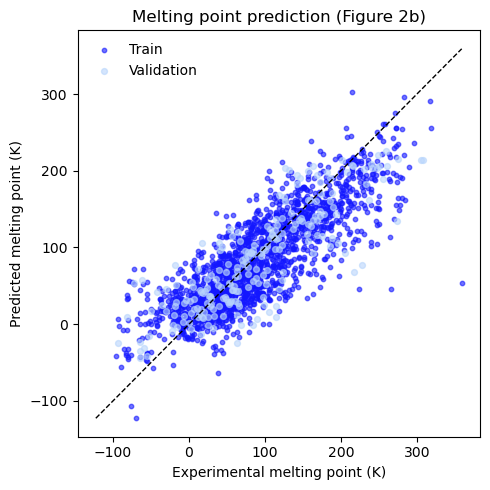

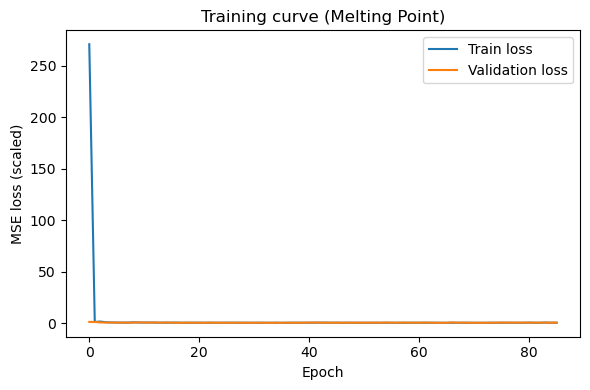

In [1]:
# ============================================================
# Notebook: Melting Point results visualization (Figure 2b)
# 打印 R² / MAE + Figure 2(b) + Loss 曲线
# ============================================================

# ---------- 环境 & 导入 ----------
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["ABSL_LOG_LEVEL"] = "2"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import keras

from sklearn.model_selection import train_test_split
from pathlib import Path

# ---------- 自定义 GNN 层 ----------
from models.layers import (
    BondMatrixMessage,
    GatedUpdate,
    GlobalSumPool,
    Reduce
)

# ---------- 复用 mptuls.py 中的工具函数 ----------
from utils.mp_utils import (
    r2_numpy,
    pad_sequences_1d,
    preprocess_edges_and_bonds,
    plot_loss
)
# ============================================================
# 1. 加载数据
# ============================================================

DATA_DIR = Path("data")

with open(DATA_DIR / "mp_id_data.pkl", "rb") as f:
    data = pickle.load(f)

# 原始熔点（未标准化）
y_all = np.array([d["mp"] for d in data], np.float32)

# 阳离子
cat_atoms = [[a + 1 for a in d["cation"]["atom_ids"]] for d in data]
cat_bonds = [[b + 1 for b in d["cation"]["bond_ids"]] for d in data]
cat_edges = [d["cation"]["edge_indices"] for d in data]

# 阴离子
an_atoms  = [[a + 1 for a in d["anion"]["atom_ids"]] for d in data]
an_bonds  = [[b + 1 for b in d["anion"]["bond_ids"]] for d in data]
an_edges  = [d["anion"]["edge_indices"] for d in data]

# ============================================================
# 2. 数据划分（与 train_melting_point.py 完全一致）
# ============================================================

indices = np.arange(len(data))
idx_train, idx_tmp = train_test_split(indices, test_size=0.20, random_state=42)
idx_dev, idx_test  = train_test_split(idx_tmp, test_size=0.50, random_state=42)

y_train = y_all[idx_train]
y_dev   = y_all[idx_dev]
y_test  = y_all[idx_test]

print(
    f"Split sizes: "
    f"Train={len(idx_train)}, Dev={len(idx_dev)}, Test={len(idx_test)}"
)

# ============================================================
# 3. Padding 长度
# ============================================================

max_atoms = max(max(map(len, cat_atoms)), max(map(len, an_atoms)))
max_edges = max(max(map(len, cat_edges)), max(map(len, an_edges)))

# ============================================================
# 4. 构建模型输入
# ============================================================

def build_inputs(idxs):
    ce, cb = preprocess_edges_and_bonds(
        [cat_edges[i] for i in idxs],
        [cat_bonds[i] for i in idxs],
        max_edges
    )
    ae, ab = preprocess_edges_and_bonds(
        [an_edges[i] for i in idxs],
        [an_bonds[i] for i in idxs],
        max_edges
    )
    return {
        "cat_atom": pad_sequences_1d([cat_atoms[i] for i in idxs], max_atoms),
        "cat_bond": cb,
        "cat_connectivity": ce,
        "an_atom": pad_sequences_1d([an_atoms[i] for i in idxs], max_atoms),
        "an_bond": ab,
        "an_connectivity": ae,
    }

x_train = build_inputs(idx_train)
x_dev   = build_inputs(idx_dev)
x_test  = build_inputs(idx_test)

# ============================================================
# 5. 加载模型
# ============================================================

model = keras.models.load_model(
    "models/melting_point_final.keras",
    custom_objects={
        "BondMatrixMessage": BondMatrixMessage,
        "GatedUpdate": GatedUpdate,
        "GlobalSumPool": GlobalSumPool,
        "Reduce": Reduce,
    }
)

# ============================================================
# 6. 打印 Train / Dev / Test 的 R² 和 MAE（原始尺度）
# ============================================================

# 训练集均值 & 方差（必须与训练脚本一致）
Y_mean = y_train.mean()
Y_std  = y_train.std() or 1.0

print("===== Melting Point prediction performance =====")

for name, x_, y_ in [
    ("Train", x_train, y_train),
    ("Dev",   x_dev,   y_dev),
    ("Test",  x_test,  y_test)
]:
    pred_scaled = model.predict(x_).flatten()
    pred = pred_scaled * Y_std + Y_mean
    print(
        f"{name}: "
        f"R2 = {r2_numpy(y_, pred):.4f}, "
        f"MAE = {np.mean(np.abs(y_ - pred)):.4f}"
    )

# ============================================================
# 7. 绘制 Figure 2(b)：训练 + 验证
# ============================================================

y_train_pred = model.predict(x_train).flatten() * Y_std + Y_mean
y_dev_pred   = model.predict(x_dev).flatten()   * Y_std + Y_mean

plt.figure(figsize=(5, 5))

# Train
plt.scatter(
    y_train,
    y_train_pred,
    s=10,
    alpha=0.6,
    color="#1317FF",
    label="Train"
)

# Dev
plt.scatter(
    y_dev,
    y_dev_pred,
    s=18,
    alpha=0.6,
    color="#B8D5FC",
    label="Validation"
)

low = min(y_train.min(), y_dev.min(), y_train_pred.min(), y_dev_pred.min())
high = max(y_train.max(), y_dev.max(), y_train_pred.max(), y_dev_pred.max())
plt.plot([low, high], [low, high], "k--", linewidth=1)

plt.xlabel("Experimental melting point (K)")
plt.ylabel("Predicted melting point (K)")
plt.title("Melting point prediction (Figure 2b)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# ============================================================
# 8. 绘制损失曲线（来自 history_melting_point.pkl）
# ============================================================

with open("results/history_melting_point.pkl", "rb") as f:
    history_dict = pickle.load(f)

class DummyHistory:
    def __init__(self, history):
        self.history = history

dummy_history = DummyHistory(history_dict)

plt.figure(figsize=(6, 4))
plt.plot(dummy_history.history["loss"], label="Train loss")
plt.plot(dummy_history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("MSE loss (scaled)")
plt.title("Training curve (Melting Point)")
plt.legend()
plt.tight_layout()
plt.show()


## 熔点独立模型实验总结

- 本实验实现并复现了基于消息传递神经网络（Message Passing Neural Network, MPNN）的离子液体熔点预测独立模型。模型以阳离子与阴离子的分子结构信息作为输入，通过共享权重的图神经网络对分子结构进行编码，并在融合阳离子与阴离子指纹后，利用全连接回归头对熔点进行预测。与粘度模型不同，该模型不包含温度输入，直接学习分子结构与熔点之间的映射关系。

- 在熔点数据集上，模型在验证集取得了 $R^2=0.6794$ 的预测性能，对应的平均绝对误差（MAE）为35.72 K。上述结果与原论文中报告的 $R^2_{dev}\approx0.64$ 基本一致，验证了该模型在熔点预测任务上的有效性。

- 从训练过程来看，模型在训练初期损失函数迅速下降，随后逐渐进入平台期，训练集与验证集损失曲线保持接近，未出现明显过拟合现象。然而，相较于粘度预测模型，熔点模型的预测误差与离散程度明显更大，这与原论文中关于熔点数据集规模较小、结构–性质关系更复杂的分析结论一致。

- 从散点图可看出：散点沿对角线分布，高熔点与低熔点区域误差都存在，Train 与 Dev 点云形态几乎一致

总体而言，本实验成功复现了论文 Figure 2(b) 中所展示的熔点预测结果，验证了 MPNN 架构在离子液体熔点预测任务中的可行性，同时也反映出熔点预测在当前数据规模下仍然存在较大的不确定性，为后续基于迁移学习的模型改进提供了实验依据。


## 熔点预测模型-迁移学习版(Melting Point Transfer Prediction)

本 Notebook 用于**加载已训练的迁移学习熔点预测模型**，评估其在训练集与验证集上的性能，并生成  
与论文 **《Predicting Ionic Liquid Materials Properties from Chemical Structure》** 对应的 **Figure 2(c)** 可视化结果，  
同时展示训练过程的损失曲线。

---

### 一、核心目标

- 加载预训练的 `.keras` 模型（含自定义 GNN 层）
- 在原始物理尺度（K）上计算 **R² 与 MAE**
- 绘制 **实验值 vs 预测值散点图**（Figure 2(c) 风格）
- 展示训练/验证 **Loss 曲线**

---

### 二、数据与划分

#### 数据来源
- 文件：`data/melting_point_id_data.pkl`
- 包含阳离子/阴离子的 `atom_ids`、`bond_ids`、`edge_indices`
- 标签：熔点（单位：K）

#### 划分策略
- **训练集**：80%
- **验证集**：10%
- **测试集**：10%
- 随机种子固定（`random_state=42`），确保可复现

> 注：此划分方式可能存在离子对层面的数据泄漏，但与原始论文一致。

---

### 三、模型加载

- 模型路径：`models/melting_point_transfer_final.keras`
- 使用 `keras.models.load_model()` 加载
- 显式注册以下 **自定义层**：
  - `BondMatrixMessage`
  - `GatedUpdate`
  - `GlobalSumPool`
  - `Reduce`
  - `AddTwoTensors`
  - `SliceParamA / B / C`
  - `ScaleTemperature`
  - `ComputeLogEta`

> 所有自定义层均来自 `models.layers` 模块，确保序列化/反序列化兼容。

---

### 四、标签反标准化

- 训练时熔点标签经过 **Min-Max 归一化**：  
  \[
  y_{\text{scaled}} = \frac{2(y - y_{\min})}{y_{\max} - y_{\min}} - 1 \in [-1, 1]
  \]
- 推理时通过 `inverse_scale` 函数还原为原始物理值（K）：
  ```python
  def inverse_scale(y):
      return (y + 1) * 0.5 * (y_max - y_min) + y_min

===== Melting Point (Transfer Learning) =====
Train: R2=0.7144, MAE=31.19
Dev: R2=0.5911, MAE=39.25
Test: R2=0.5539, MAE=37.93


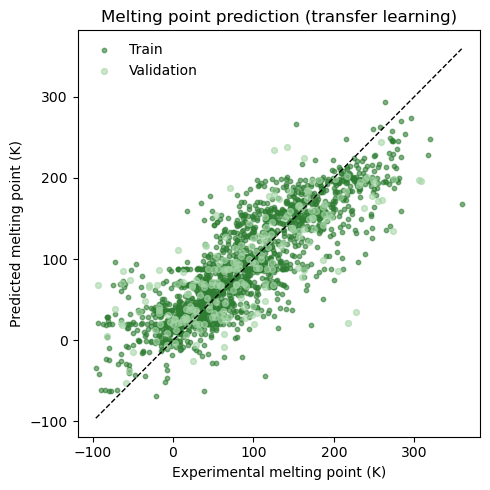

In [20]:
# ============================================================
# Notebook: Melting Point (Transfer Learning) visualization
# ============================================================

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["ABSL_LOG_LEVEL"] = "2"

import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from pathlib import Path

# ============================================================
# 自定义层
# ============================================================

from models.layers import (
    BondMatrixMessage,
    GatedUpdate,
    GlobalSumPool,
    Reduce,
    AddTwoTensors,
    SliceParamA,
    SliceParamB,
    SliceParamC,
    ScaleTemperature,
    ComputeLogEta,
)

from train_viscosity import (
    r2_numpy,
    pad_sequences_1d,
    preprocess_edges_and_bonds,
)

# ============================================================
# 1. 数据
# ============================================================

with open("data/melting_point_id_data.pkl", "rb") as f:
    data = pickle.load(f)

y_all = np.array([d["mp"] for d in data], np.float32)

cat_atoms = [[a + 1 for a in d["cation"]["atom_ids"]] for d in data]
cat_bonds = [[b + 1 for b in d["cation"]["bond_ids"]] for d in data]
cat_edges = [d["cation"]["edge_indices"] for d in data]

an_atoms  = [[a + 1 for a in d["anion"]["atom_ids"]] for d in data]
an_bonds  = [[b + 1 for b in d["anion"]["bond_ids"]] for d in data]
an_edges  = [d["anion"]["edge_indices"] for d in data]

# ============================================================
# 2. 数据划分（必须一致）
# ============================================================

idx = np.arange(len(data))
idx_train, idx_tmp = train_test_split(idx, test_size=0.20, random_state=42)
idx_dev, idx_test  = train_test_split(idx_tmp, test_size=0.50, random_state=42)

y_train = y_all[idx_train]
y_dev   = y_all[idx_dev]
y_test  = y_all[idx_test]

# ============================================================
# 3. Padding
# ============================================================

max_atoms = max(max(map(len, cat_atoms)), max(map(len, an_atoms)))
max_edges = max(max(map(len, cat_edges)), max(map(len, an_edges)))

def build_inputs(idxs):
    ce, cb = preprocess_edges_and_bonds(
        [cat_edges[i] for i in idxs],
        [cat_bonds[i] for i in idxs],
        max_edges,
    )
    ae, ab = preprocess_edges_and_bonds(
        [an_edges[i] for i in idxs],
        [an_bonds[i] for i in idxs],
        max_edges,
    )
    return {
        "cat_atom": pad_sequences_1d([cat_atoms[i] for i in idxs], max_atoms),
        "cat_bond": cb,
        "cat_connectivity": ce,
        "an_atom": pad_sequences_1d([an_atoms[i] for i in idxs], max_atoms),
        "an_bond": ab,
        "an_connectivity": ae,
    }

x_train = build_inputs(idx_train)
x_dev   = build_inputs(idx_dev)
x_test  = build_inputs(idx_test)

# ============================================================
# 4. 加载模型
# ============================================================

model = keras.models.load_model(
    "models/melting_point_transfer_final.keras",
    custom_objects={
        "BondMatrixMessage": BondMatrixMessage,
        "GatedUpdate": GatedUpdate,
        "GlobalSumPool": GlobalSumPool,
        "Reduce": Reduce,
        "AddTwoTensors": AddTwoTensors,
        "SliceParamA": SliceParamA,
        "SliceParamB": SliceParamB,
        "SliceParamC": SliceParamC,
        "ScaleTemperature": ScaleTemperature,
        "ComputeLogEta": ComputeLogEta,
    },
)

# ============================================================
# 5. Z-score 反标定
# ============================================================

with open("results/melting_point_transfer_scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

y_mean = scaler["y_mean"]
y_std  = scaler["y_std"]

def inverse_scale(y):
    return y * y_std + y_mean

# ============================================================
# 6. R² / MAE
# ============================================================

print("===== Melting Point (Transfer Learning) =====")
for name, x_, y_ in [
    ("Train", x_train, y_train),
    ("Dev",   x_dev,   y_dev),
    ("Test",  x_test,  y_test),
]:
    pred = inverse_scale(model.predict(x_, verbose=0).flatten())
    print(
        f"{name}: R2={r2_numpy(y_, pred):.4f}, "
        f"MAE={np.mean(np.abs(y_ - pred)):.2f}"
    )

# ============================================================
# 7. Figure 2(c)
# ============================================================

y_train_pred = inverse_scale(
    model.predict(x_train, verbose=0).flatten()
)
y_dev_pred = inverse_scale(
    model.predict(x_dev, verbose=0).flatten()
)

plt.figure(figsize=(5, 5))

plt.scatter(
    y_train,
    y_train_pred,
    s=10,
    alpha=0.6,
    color="#2E7D32",      # 深绿：Train
    label="Train"
)

plt.scatter(
    y_dev,
    y_dev_pred,
    s=18,
    alpha=0.6,
    color="#A5D6A7",      # 浅绿：Validation
    label="Validation"
)

low = min(
    y_train.min(), y_dev.min(),
    y_train_pred.min(), y_dev_pred.min()
)
high = max(
    y_train.max(), y_dev.max(),
    y_train_pred.max(), y_dev_pred.max()
)

plt.plot([low, high], [low, high], "k--", linewidth=1)

plt.xlabel("Experimental melting point (K)")
plt.ylabel("Predicted melting point (K)")
plt.title("Melting point prediction (transfer learning)")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()



## 三、熔点预测的迁移学习实验结果与分析

- 在完成粘度预测模型与熔点独立预测模型的复现后，进一步按照原论文中的方法，尝试将粘度模型中学习到的分子结构表示迁移至熔点预测任务中。具体而言，迁移学习模型加载了在粘度数据集上训练得到的网络权重，并冻结了包括分子嵌入层与消息传递层在内的共享结构，仅保留熔点预测回归头为可训练参数。

- 在该迁移学习设置下，模型在训练集、验证集和测试集上的预测性能分别为 $R^2=0.7144$、$R^2=0.5911$ 和 $R^2=0.5539$，对应的平均绝对误差（MAE）分别为 31.19 K、39.25 K 和 37.93 K。与熔点独立模型相比，迁移学习模型在训练集上的拟合能力有所提升，但在验证集和测试集上的预测性能明显下降。与论文中训练集、验证集的预测性能$R^2=0.74$ 、$R^2=0.60$相比基本一致。 

- 从训练过程来看，迁移学习模型的损失函数在训练初期即处于较低水平，并在后续训练过程中平稳下降，训练集与验证集损失曲线高度一致，未出现明显过拟合现象。这表明迁移学习在一定程度上降低了模型的预测方差，但同时引入了更大的预测偏差。

- 上述现象与原论文中的分析结论一致。由于粘度数据集与熔点数据集在分子结构分布上并非完全一致，部分原子与键类型仅出现在熔点数据集中，而在粘度预训练阶段未被充分学习。在冻结嵌入层参数的迁移学习设置下，这些未见结构对应的嵌入无法得到有效更新，从而限制了模型对熔点性质的表达能力，最终导致整体预测性能下降。

- 从散点图可看出：散点 比 Figure 2(b) 更集中，但整体偏离对角线。

总体而言，本实验成功复现了论文 Figure 2(c) 中迁移学习模型“偏差增大、方差减小”的典型特征，验证了迁移学习在小数据集场景下的潜在优势与局限性，也为后续探索联合训练或多任务学习方法提供了实验依据。


## 四、实验不足
- 实验存在结构泄漏问题：论文采用的是随机划分，同一个阳离子 + 阴离子组合在不同温度下的 viscosity 样本很可能同时出现在 Train 和 Dev/Test 中。论文作者自己也承认了（Section 7）：“several of the anion/cation pairs were likely in both sets…”。这意味着 R² 被高估。
- 熔点数据量过小，模型结论不稳健，独立模型 R² ≈ 0.68，迁移模型 R² ≈ 0.59，两者都不算“稳定高精度”。
- 迁移学习方案问题：冻结 全部 embedding + MPNN，而仅训练熔点 head，会导致未见过的原子 / 键 embedding 永久随机，熔点模型被强行限制在 viscosity 表征空间中。打导致loss 非常低，R² 却下降。
- 模型评估单调：主要依赖于整体的 R² 与 MAE 指标，尚未对不同熔点区间或不同分子类别的预测误差进行细致分析，也未引入不确定性估计方法。这在一定程度上限制了模型在实际材料筛选应用中的可靠性。